In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

from sktime.forecasting.darts import DartsLinearRegressionModel, DartsXGBModel
from sktime.transformations.panel.reduce import Tabularizer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import ARIMA
from sktime.pipeline import make_pipeline

import tensorflow as tf

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
ac = pd.read_csv("/content/ac.csv")
bbd = pd.read_csv("/content/bbd.csv")
cm = pd.read_csv("/content/cm.csv")
cnq = pd.read_csv("/content/cnq.csv")
td = pd.read_csv("/content/td.csv")

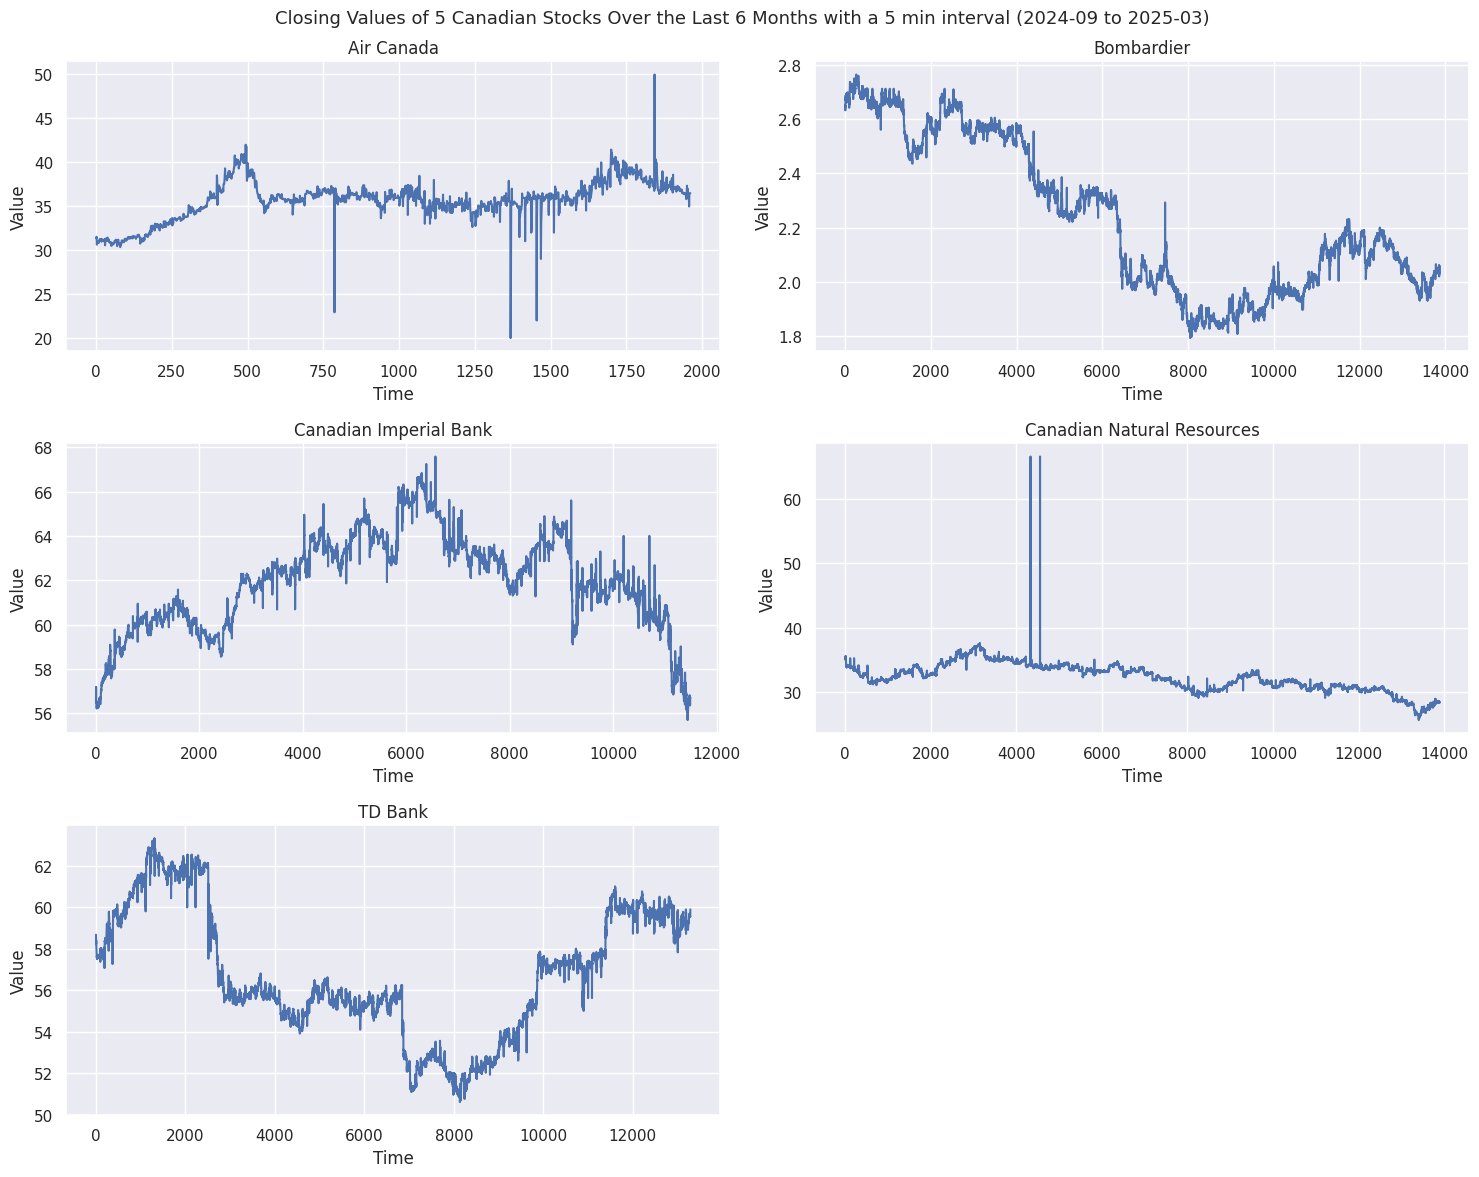

In [4]:
datasets = [("Air Canada", "ac", ac), ("Bombardier", "bbd", bbd), ("Canadian Imperial Bank", "cm", cm), ("Canadian Natural Resources", "cnq", cnq), ("TD Bank", "td", td)]

plt.figure(figsize = [15,12])
plt.suptitle("Closing Values of 5 Canadian Stocks Over the Last 6 Months with a 5 min interval (2024-09 to 2025-03)", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(data[2]["close"])
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Train Test Validation split**

In [5]:
for _, var, data in datasets:
    globals()[f"train_{var}"] = data["close"].iloc[:int(data.shape[0] * 0.75)]
    globals()[f"test_{var}"] = data["close"].iloc[int(data.shape[0] * 0.75):int(data.shape[0] * 0.95)]
    globals()[f"val_{var}"] = data["close"].iloc[int(data.shape[0] * 0.95):]
    print(f"{var} : ", globals()[f"train_{var}"].shape, globals()[f"test_{var}"].shape, globals()[f"val_{var}"].shape)

ac :  (1471,) (392,) (99,)
bbd :  (10398,) (2772,) (694,)
cm :  (8620,) (2299,) (575,)
cnq :  (10419,) (2778,) (695,)
td :  (9964,) (2657,) (665,)


**Method 1 : Mean Method**

In [ ]:
y_hat = [np.mean(globals()[f"train_{var}"]) for _, var, data in datasets]

In [ ]:
method_1_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_1_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))
    method_1_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))
    method_1_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))

method_1_metrics

,ac,bbd,cm,cnq,td
MSE,8.040621,0.044575,1.806891,8.101477,7.386776
MAE,2.386487,0.197754,1.134639,2.712041,2.367883
R^2,-2.157679,-7.15159,-0.04229,-9.855381,-2.95329


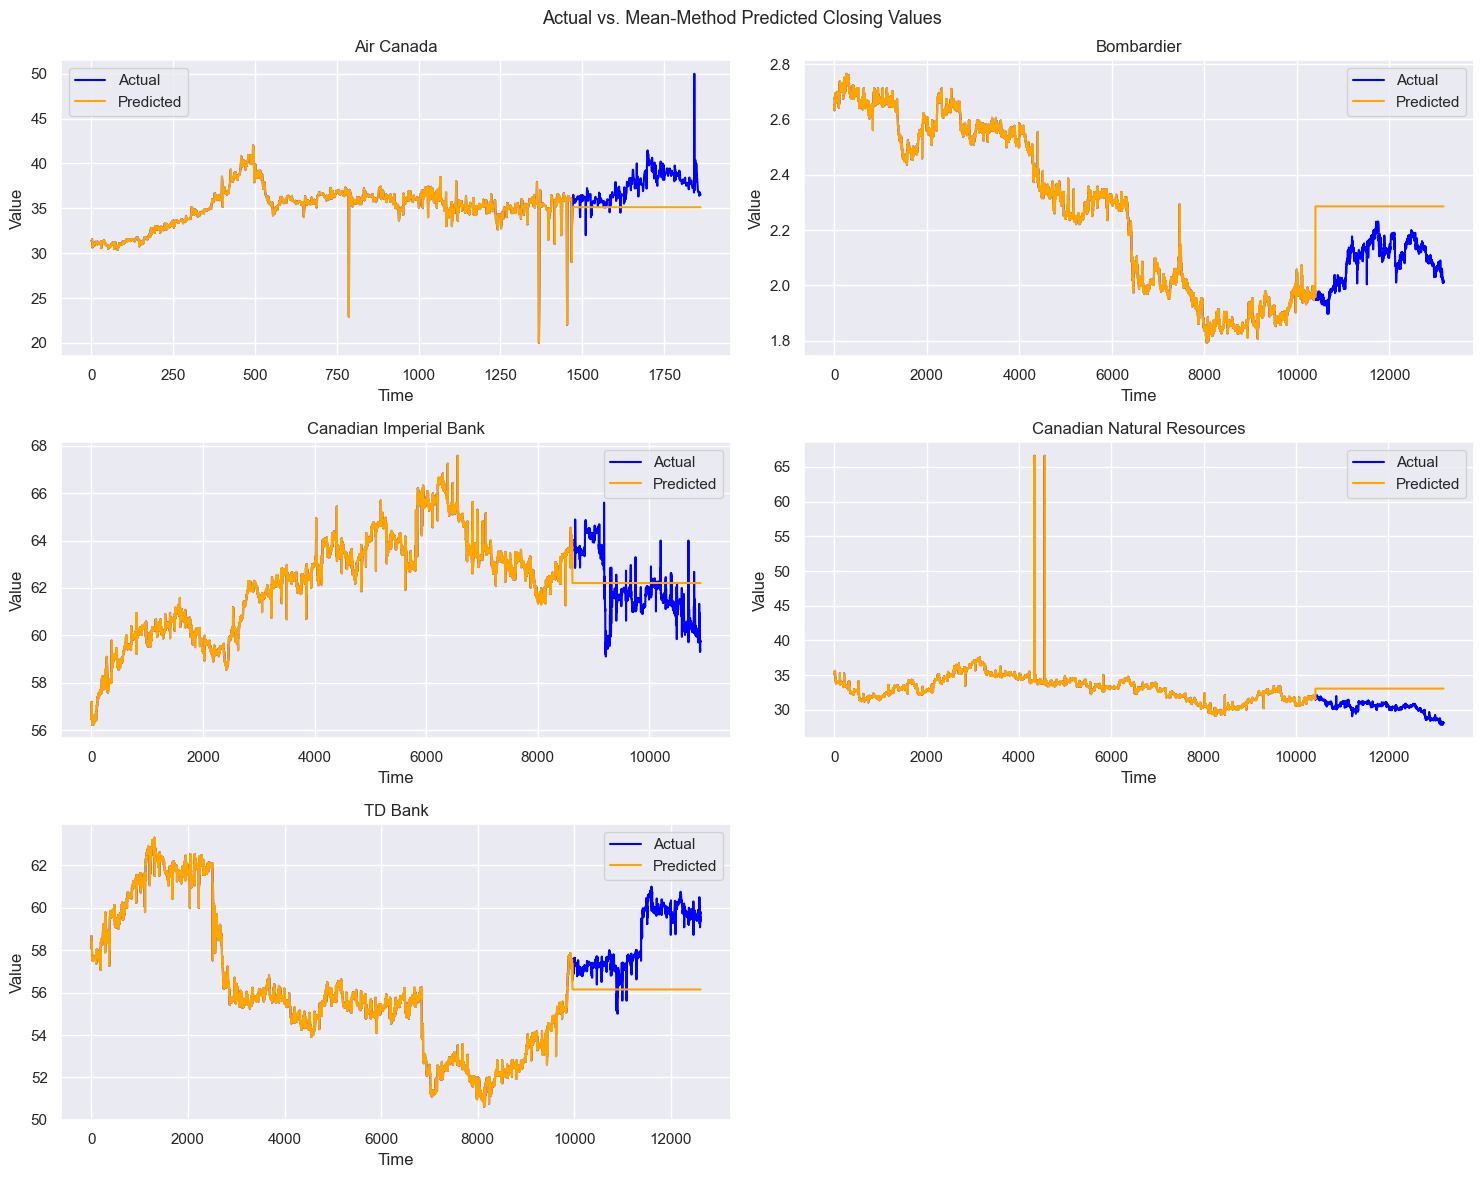

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Mean-Method Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], [y_hat[_]] * len(globals()[f"test_{data[1]}"]))), label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 2 Naive Method**

In [ ]:
y_hat = [globals()[f"train_{val}"].iloc[-1] for _, val, data in datasets]

In [ ]:
method_2_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_2_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))
    method_2_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))
    method_2_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], [y_hat[idx]] * len(globals()[f"test_{val[1]}"]))

method_2_metrics

,ac,bbd,cm,cnq,td
MSE,14.466995,0.022476,5.818551,2.259846,5.42716
MAE,3.462932,0.133189,2.109914,1.243902,1.922606
R^2,-4.681418,-3.110329,-2.356384,-2.028026,-1.904533


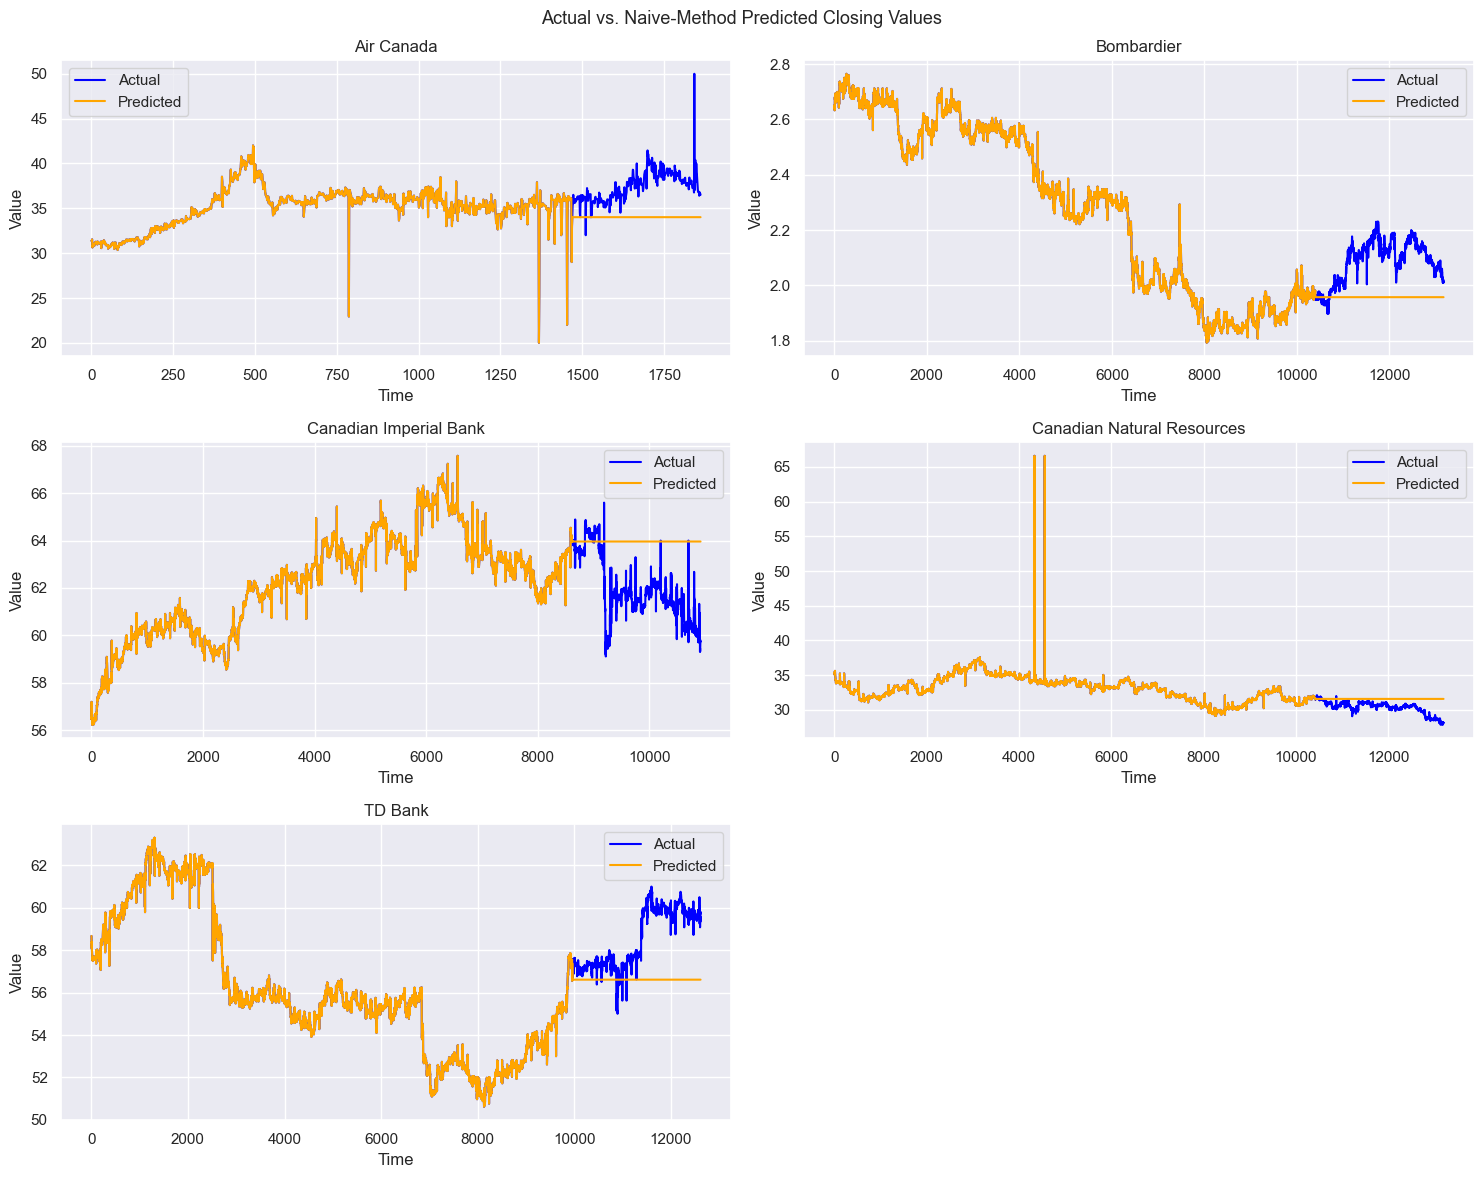

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Naive-Method Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], [y_hat[_]] * len(globals()[f"test_{data[1]}"]))), label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 3 : Simple Moving Average**

In [ ]:
y_hat = []

for idx, val in enumerate(datasets):
    temp =  globals()[f"train_{val[1]}"].copy()

    curr_idx = temp.shape[0]
    while curr_idx <= globals()[f"test_{val[1]}"].index[-1]:
        temp.loc[curr_idx] = temp.iloc[-5:].mean()
        curr_idx += 1

    y_hat.append(list(temp))

In [ ]:
method_3_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_3_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_3_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_3_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_3_metrics

,ac,bbd,cm,cnq,td
MSE,21.016384,0.019984,5.888917,2.349973,4.022858
MAE,4.302898,0.12503,2.123334,1.277375,1.547784
R^2,-7.253466,-2.654567,-2.396974,-2.14879,-1.152973


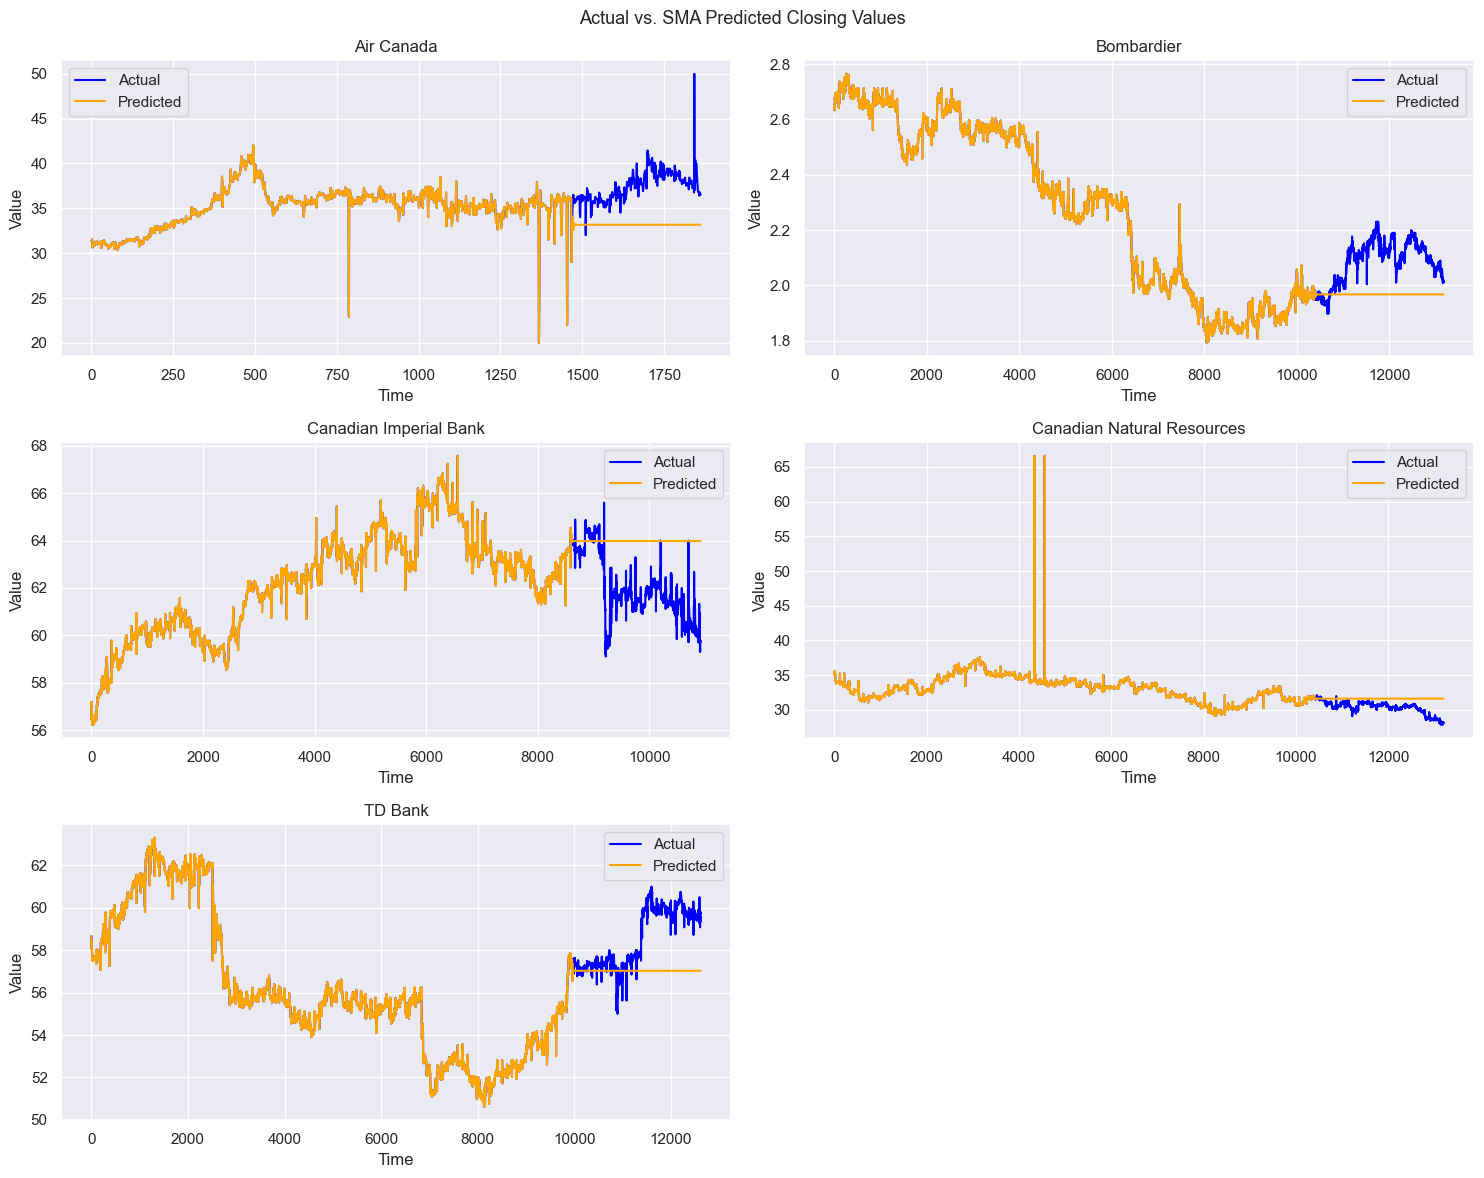

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. SMA Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 4 : Exponential Weighted Moving Average**

In [ ]:
y_hat = []

for idx, val in enumerate(datasets):
    temp =  globals()[f"train_{val[1]}"].copy()

    curr_idx = temp.shape[0]
    while curr_idx <= globals()[f"test_{val[1]}"].index[-1]:
        temp.loc[curr_idx] = temp.ewm(alpha = 0.5, adjust = False).mean().iloc[-1]
        curr_idx += 1

    y_hat.append(list(temp))

In [ ]:
method_4_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_4_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_4_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_4_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_4_metrics

,ac,bbd,cm,cnq,td
MSE,19.063479,0.020694,5.888038,2.331915,4.238291
MAE,4.07126,0.127401,2.123165,1.270714,1.607866
R^2,-6.486529,-2.784482,-2.396467,-2.124593,-1.268269


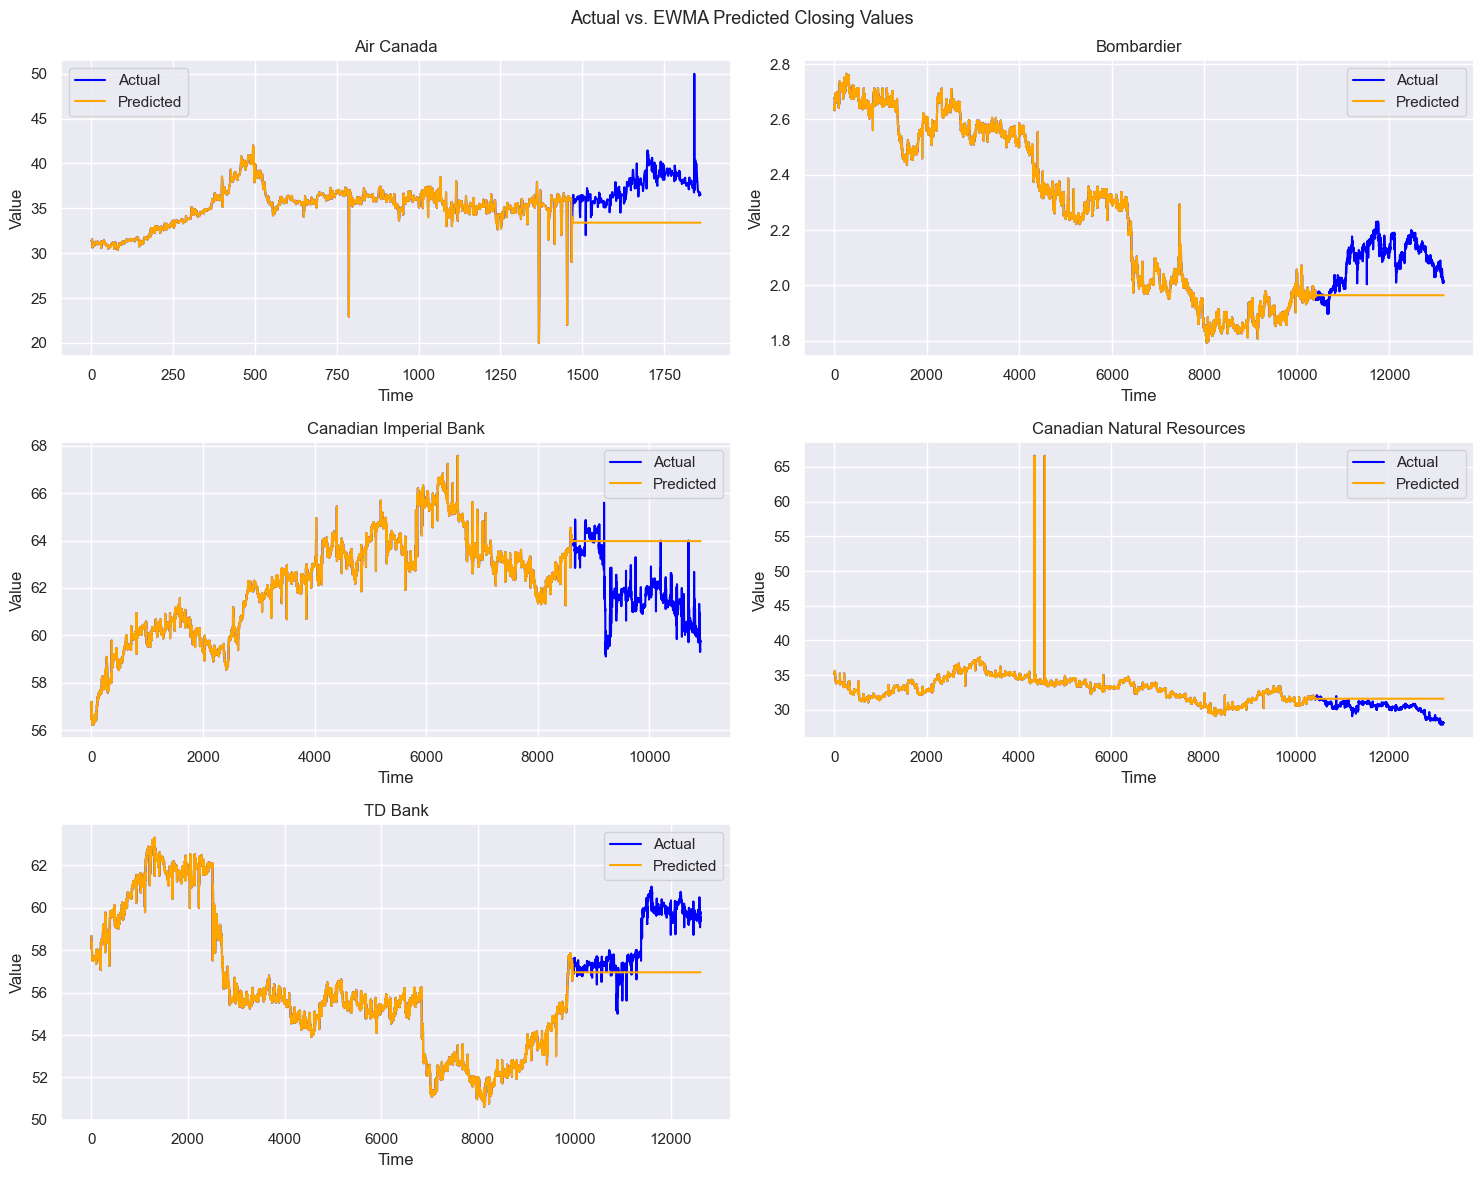

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. EWMA Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 5 : Univariate Linear Regression Model**

In [ ]:
for _, val in enumerate(datasets):
    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = [], []
    for i in range(len(globals()[f"train_{val[1]}"]) - 5):
        globals()[f"X_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i:i+5].to_list())
        globals()[f"y_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i+5])

    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = [], []
    for j in range(len(globals()[f"test_{val[1]}"]) - 5):
        globals()[f"X_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j:j+5].to_list())
        globals()[f"y_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j+5])

    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = np.array(globals()[f"X_tr_{val[1]}"]), np.array(globals()[f"y_tr_{val[1]}"])
    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = np.array(globals()[f"X_te_{val[1]}"]), np.array(globals()[f"y_te_{val[1]}"])

In [ ]:
for _, name, data in datasets:
    globals()[f"reg_{name}"] = LinearRegression().fit(globals()[f"X_tr_{name}"], globals()[f"y_tr_{name}"])

In [ ]:
y_hat = [np.concatenate((np.array(globals()[f"train_{name}"]), globals()[f"reg_{name}"].predict(globals()[f"X_te_{name}"]))) for _, name, data in datasets]

In [ ]:
method_5_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_5_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_5_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_5_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_5_metrics

,ac,bbd,cm,cnq,td
MSE,0.782074,0.0001,0.068108,0.009778,0.032656
MAE,0.500367,0.006888,0.13242,0.068251,0.100239
R^2,0.695576,0.981757,0.960557,0.986763,0.982531


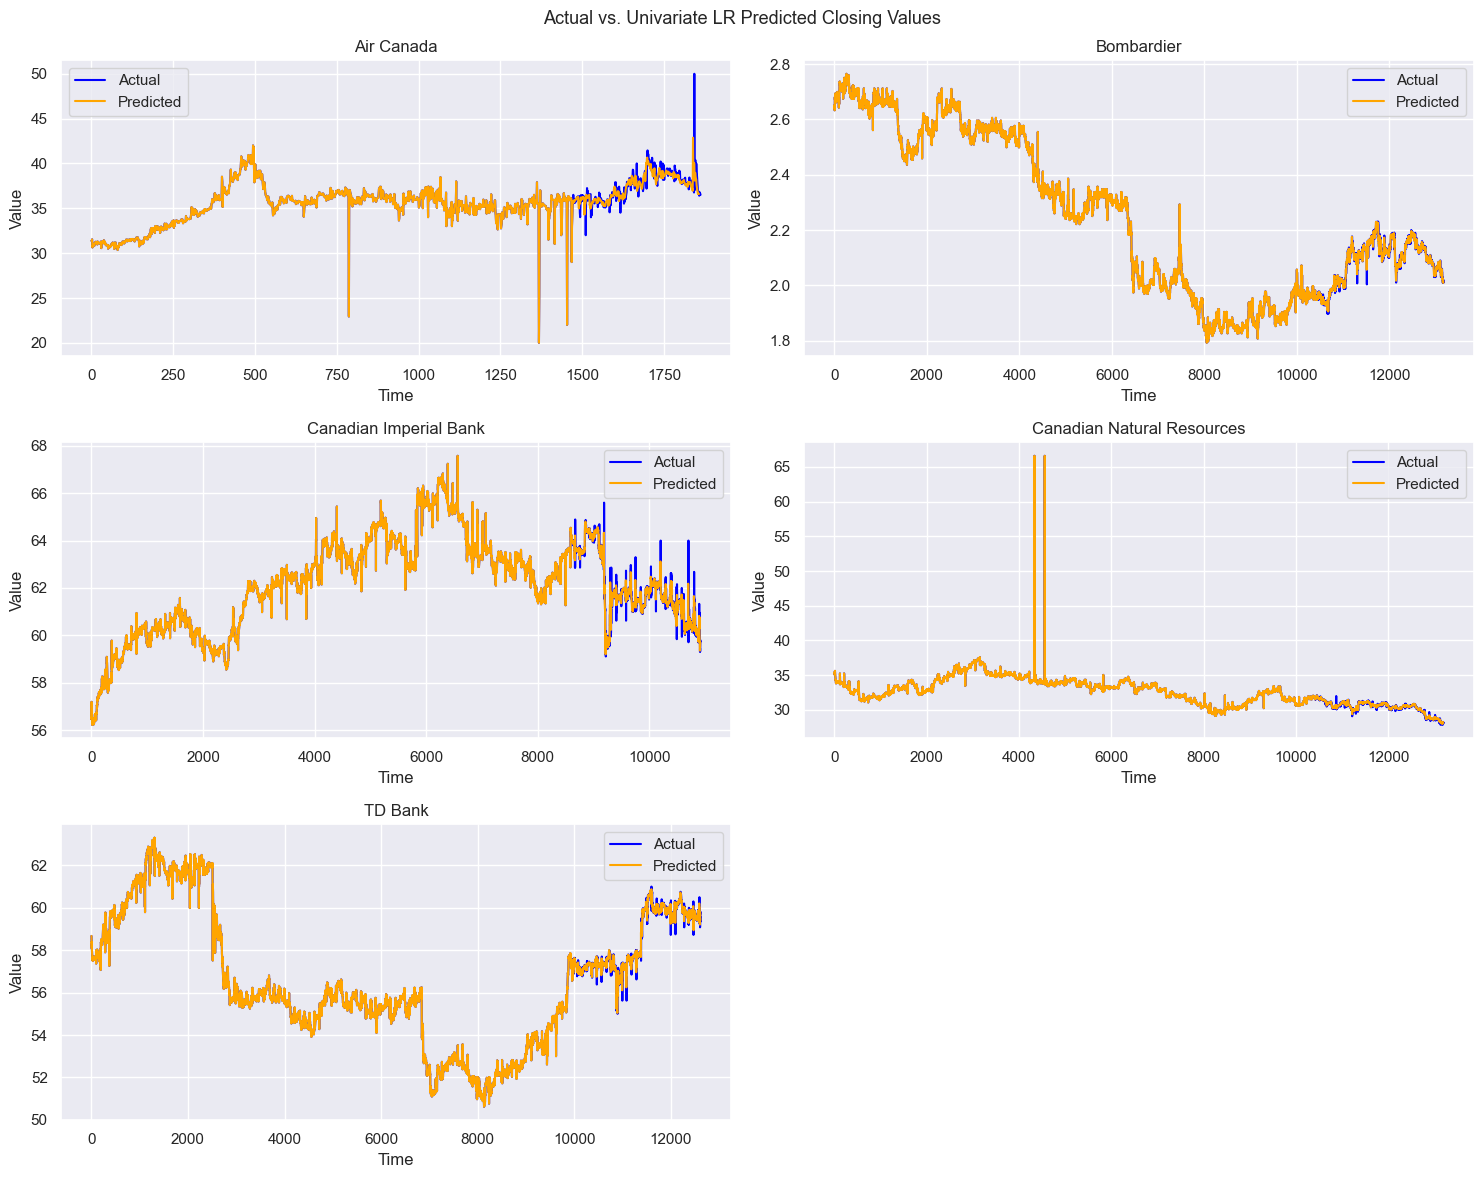

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Univariate LR Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 6 : Theta Forecaster**

In [ ]:
for _, name, data in datasets:
    globals()[f"fh_{name}"] = ForecastingHorizon(range(1, len(globals()[f"test_{name}"]) + 1), is_relative = True)

    globals()[f"forecaster_{name}"] = ThetaForecaster(sp = 1)

    globals()[f"forecaster_{name}"].fit(globals()[f"train_{name}"], fh = globals()[f"fh_{name}"])

In [ ]:
coverage = 0.9
for _, name, data in datasets:
    globals()[f"y_pred_ints_{name}"] = globals()[f"forecaster_{name}"].predict_interval(coverage = coverage)

In [ ]:
y_hat = [np.concatenate((globals()[f"train_{name}"], globals()[f"forecaster_{name}"].predict())) for _, name, data in datasets]

In [ ]:
method_6_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_6_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_6_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_6_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_6_metrics

,ac,bbd,cm,cnq,td
MSE,13.229289,0.046428,7.994822,1.783784,7.613921
MAE,3.309999,0.193409,2.46996,1.09547,2.226341
R^2,-4.195351,-7.490532,-3.611748,-1.390139,-3.074854


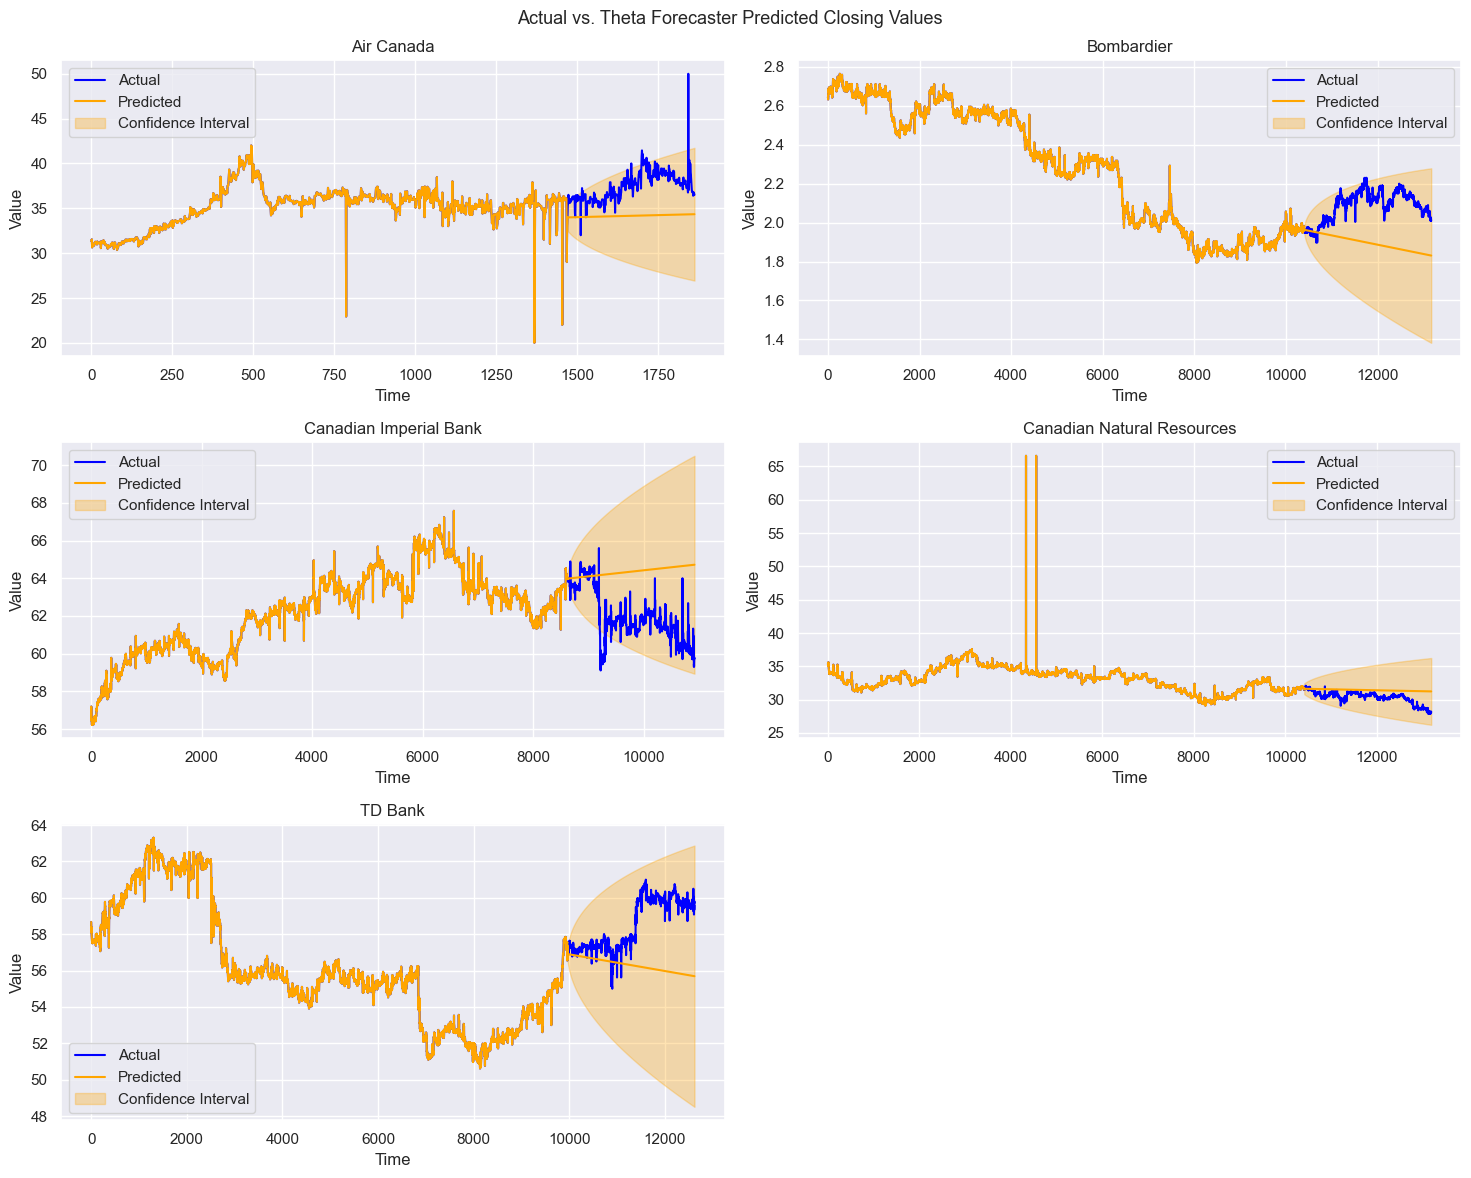

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Theta Forecaster Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.fill_between(list(range(len(globals()[f"train_{data[1]}"]), len(globals()[f"train_{data[1]}"]) + len(globals()[f"test_{data[1]}"]))), globals()[f"y_pred_ints_{data[1]}"].iloc[:,0], globals()[f"y_pred_ints_{data[1]}"].iloc[:,1],
                    color = "orange", alpha = 0.3, label = "Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 7 : ARIMA**

In [ ]:
for _, name, data in tqdm(datasets):
    globals()[f"fh_{name}"] = ForecastingHorizon(range(1, len(globals()[f"test_{name}"]) + 1), is_relative = True)

    globals()[f"forecaster_{name}"] = ARIMA(order = (1,1,1), seasonal_order = (1,1,1,30))

    globals()[f"forecaster_{name}"].fit(globals()[f"train_{name}"], fh = globals()[f"fh_{name}"])

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [53:13<00:00, 638.63s/it]


In [ ]:
y_hat = [np.concatenate((globals()[f"train_{name}"], globals()[f"forecaster_{name}"].predict())) for _, name, data in datasets]

In [ ]:
method_7_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_7_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_7_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_7_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_7_metrics

,ac,bbd,cm,cnq,td
MSE,27.126177,0.311839,4.209134,5.258524,0.761425
MAE,4.620212,0.465541,1.797791,1.945094,0.681322
R^2,-9.652878,-56.02719,-1.428004,-6.046033,0.592497


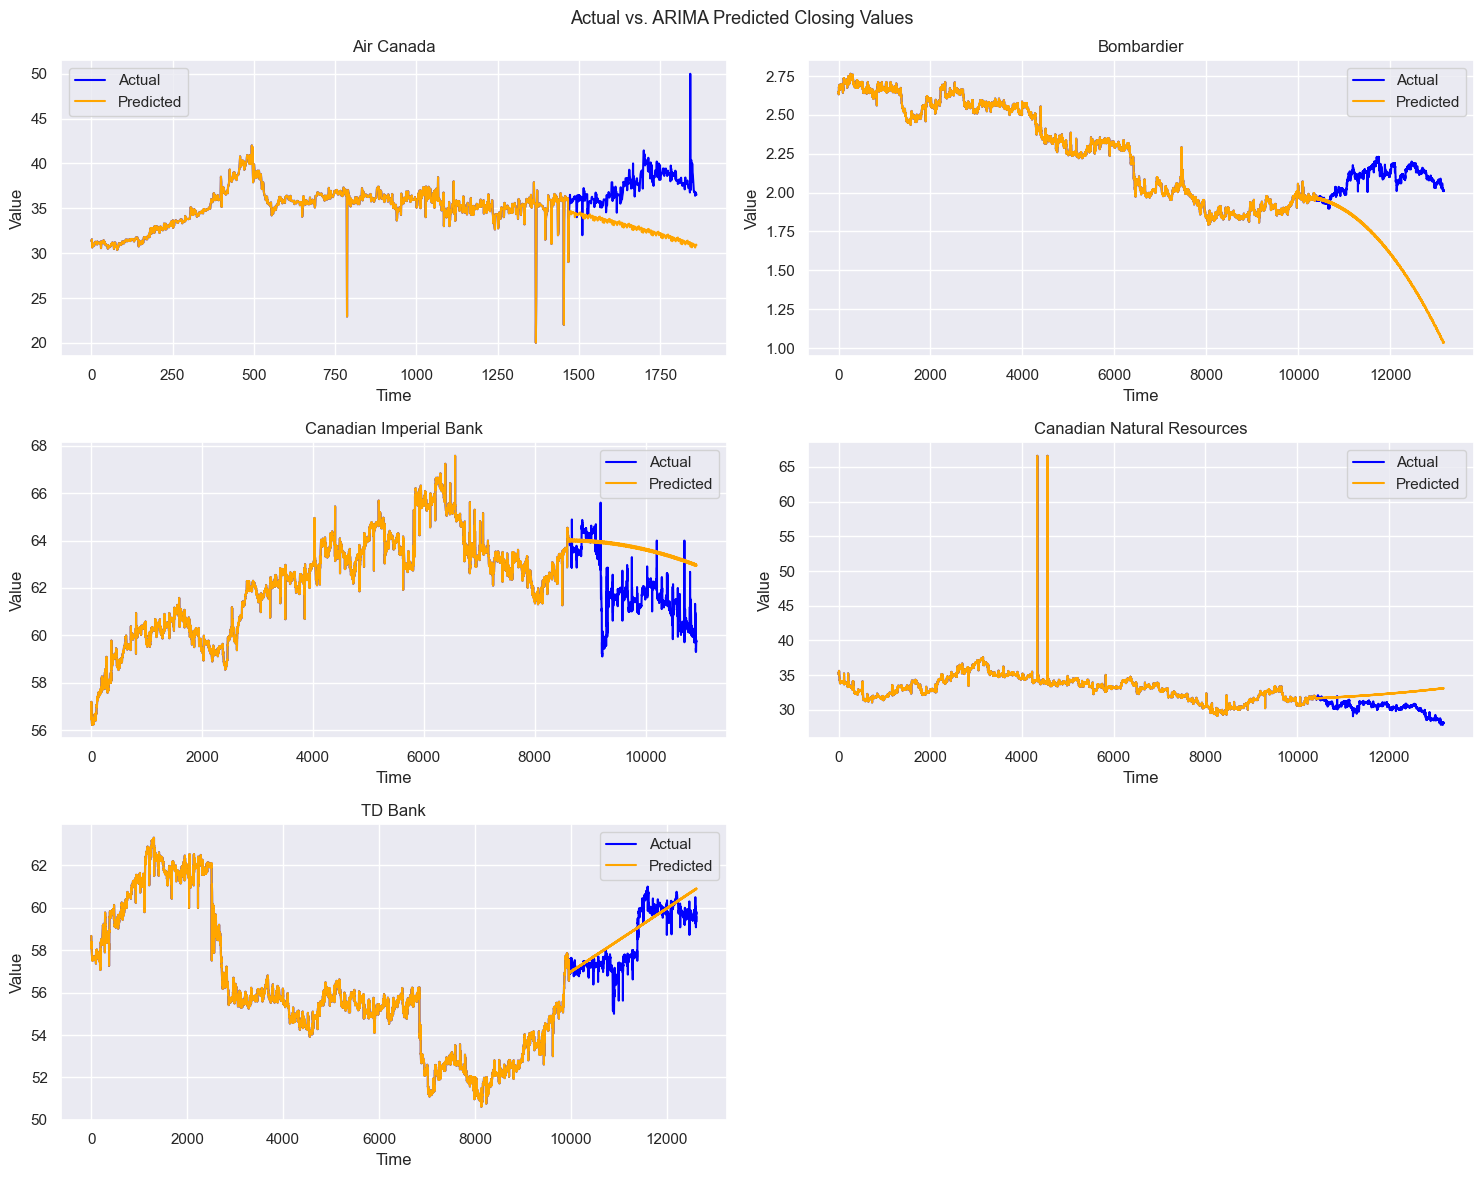

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. ARIMA Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 8 : Darts Linear Regression Model**

In [ ]:
for _, name, data in tqdm(datasets):

    globals()[f"forecaster_{name}"] = DartsLinearRegressionModel(lags = len(globals()[f"test_{name}"]) * 2, output_chunk_length = len(globals()[f"test_{name}"]))

    globals()[f"forecaster_{name}"].fit(globals()[f"train_{name}"])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:11<00:00, 50.23s/it]


In [ ]:
y_hat = [np.concatenate((globals()[f"train_{name}"], globals()[f"forecaster_{name}"].predict(list(range(1, len(globals()[f"test_{name}"]) + 1))))) for _, name, data in datasets]

In [ ]:
method_8_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_8_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_8_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_8_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_8_metrics

,ac,bbd,cm,cnq,td
MSE,9.893403,0.240937,6.341364,2.606632,31.459877
MAE,2.477238,0.438473,2.026102,1.25346,5.424272
R^2,-2.885296,-43.061086,-2.657964,-2.492695,-15.836847


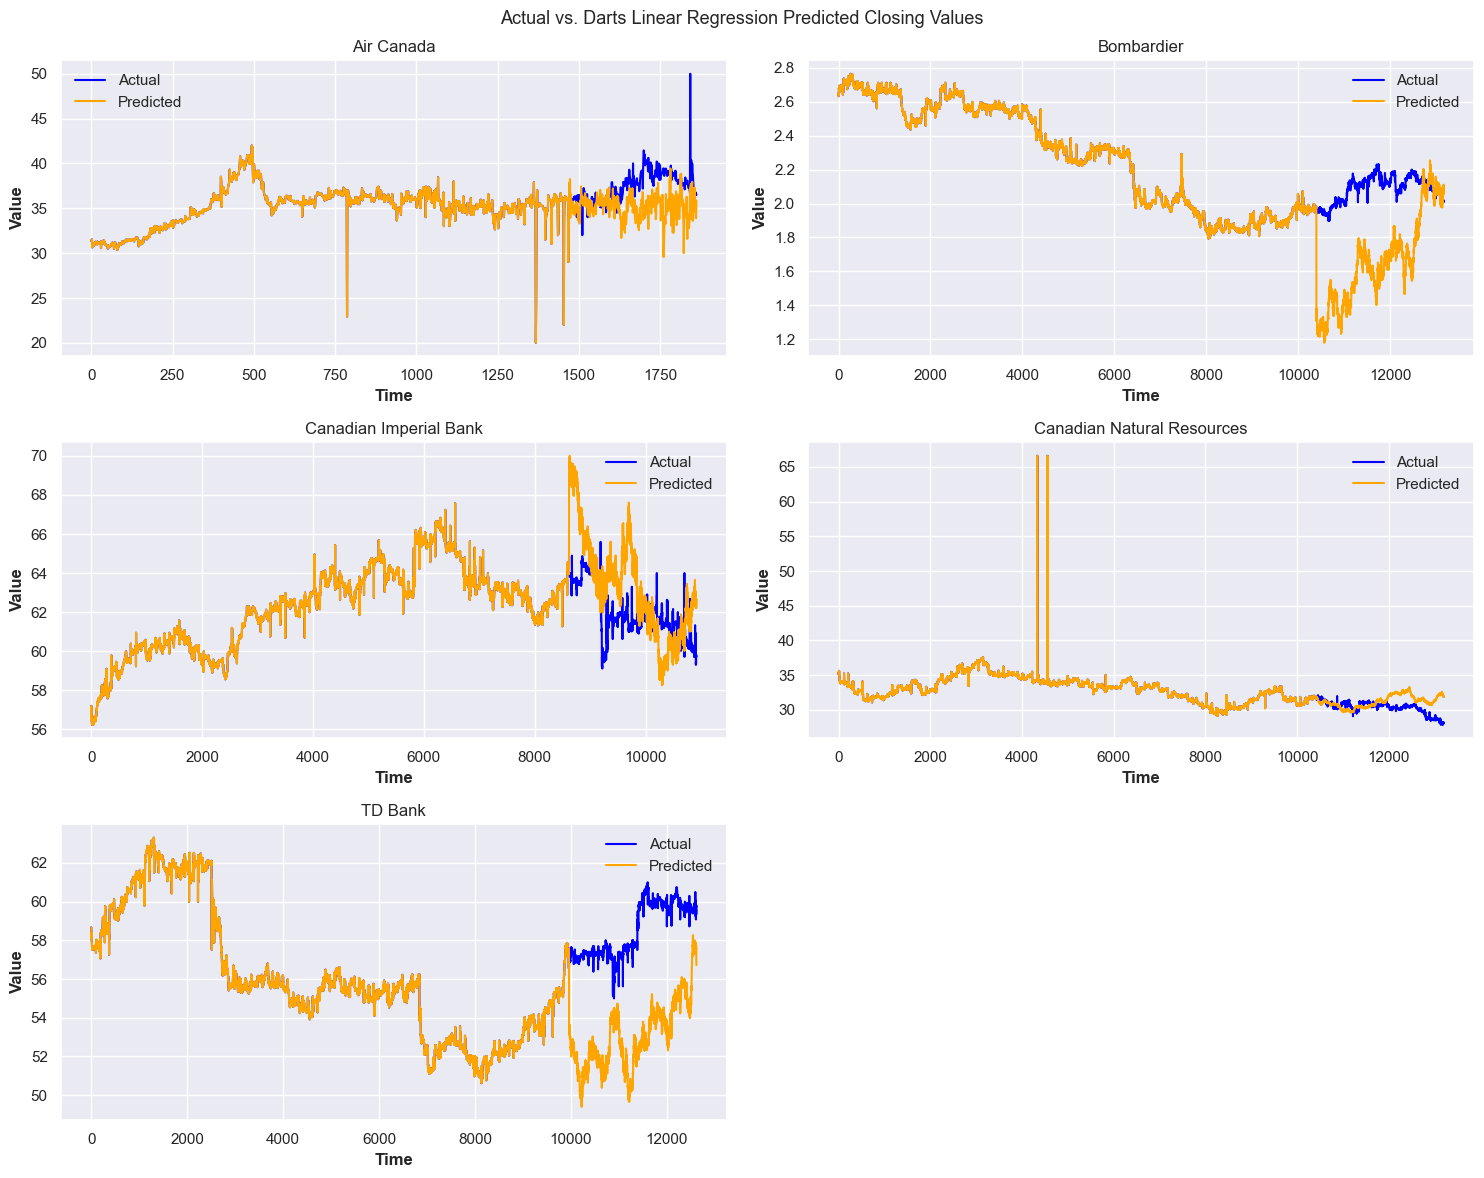

In [ ]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Darts Linear Regression Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 9 : Multivariate FFNN**

In [9]:
for _, val in enumerate(datasets):
    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = [], []
    for i in range(len(globals()[f"train_{val[1]}"]) - 5):
        globals()[f"X_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i:i+5].to_list())
        globals()[f"y_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i+5])

    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = [], []
    for j in range(len(globals()[f"test_{val[1]}"]) - 5):
        globals()[f"X_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j:j+5].to_list())
        globals()[f"y_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j+5])

    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = np.array(globals()[f"X_tr_{val[1]}"]), np.array(globals()[f"y_tr_{val[1]}"])
    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = np.array(globals()[f"X_te_{val[1]}"]), np.array(globals()[f"y_te_{val[1]}"])

    globals()[f"X_tr_{val[1]}"] = (globals()[f"X_tr_{val[1]}"] - globals()[f"X_tr_{val[1]}"].mean(axis = 0)) / globals()[f"X_tr_{val[1]}"].std(axis = 0)
    globals()[f"X_te_{val[1]}"] = (globals()[f"X_te_{val[1]}"] - globals()[f"X_tr_{val[1]}"].mean(axis = 0)) / globals()[f"X_tr_{val[1]}"].std(axis = 0)

In [11]:
for _, name, data in datasets:
  globals()[f"model_{name}"] = tf.keras.Sequential(
      [
          tf.keras.layers.Dense(1, activation = 'sigmoid'),
          tf.keras.layers.Dense(1, activation = 'linear')
      ]
  )

  globals()[f"model_{name}"].compile(optimizer = "adam", loss = "mse", metrics = ["R2Score"])

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor = "val_loss",
      patience = 5
  )

  globals()[f"network_{name}"] = globals()[f"model_{name}"].fit(
      globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"],
      validation_data = (globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"]),
      batch_size = 8,
      epochs = 1000,
      shuffle = True,
      callbacks = [early_stopping]
  )

Epoch 1/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - R2Score: -297.6761 - loss: 3193.0171 - val_R2Score: -1783.2578 - val_loss: 3333.0366
Epoch 2/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -282.3502 - loss: 2996.4668 - val_R2Score: -1648.1116 - val_loss: 3080.5803
Epoch 3/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -266.6501 - loss: 2812.1692 - val_R2Score: -1487.6943 - val_loss: 2780.9170
Epoch 4/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -235.6242 - loss: 2523.0298 - val_R2Score: -1338.3619 - val_loss: 2501.9604
Epoch 5/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -210.8879 - loss: 2244.6362 - val_R2Score: -1207.3927 - val_loss: 2257.3066
Epoch 6/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -191.2281 - loss: 2001.9503 - val_R2Score: -1086.8226 - val_loss: 2032.0790
Epoch 7/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -166.7539 - loss: 1794.0122 - val_R2Score: -974.3116 - val_loss: 1821.9055


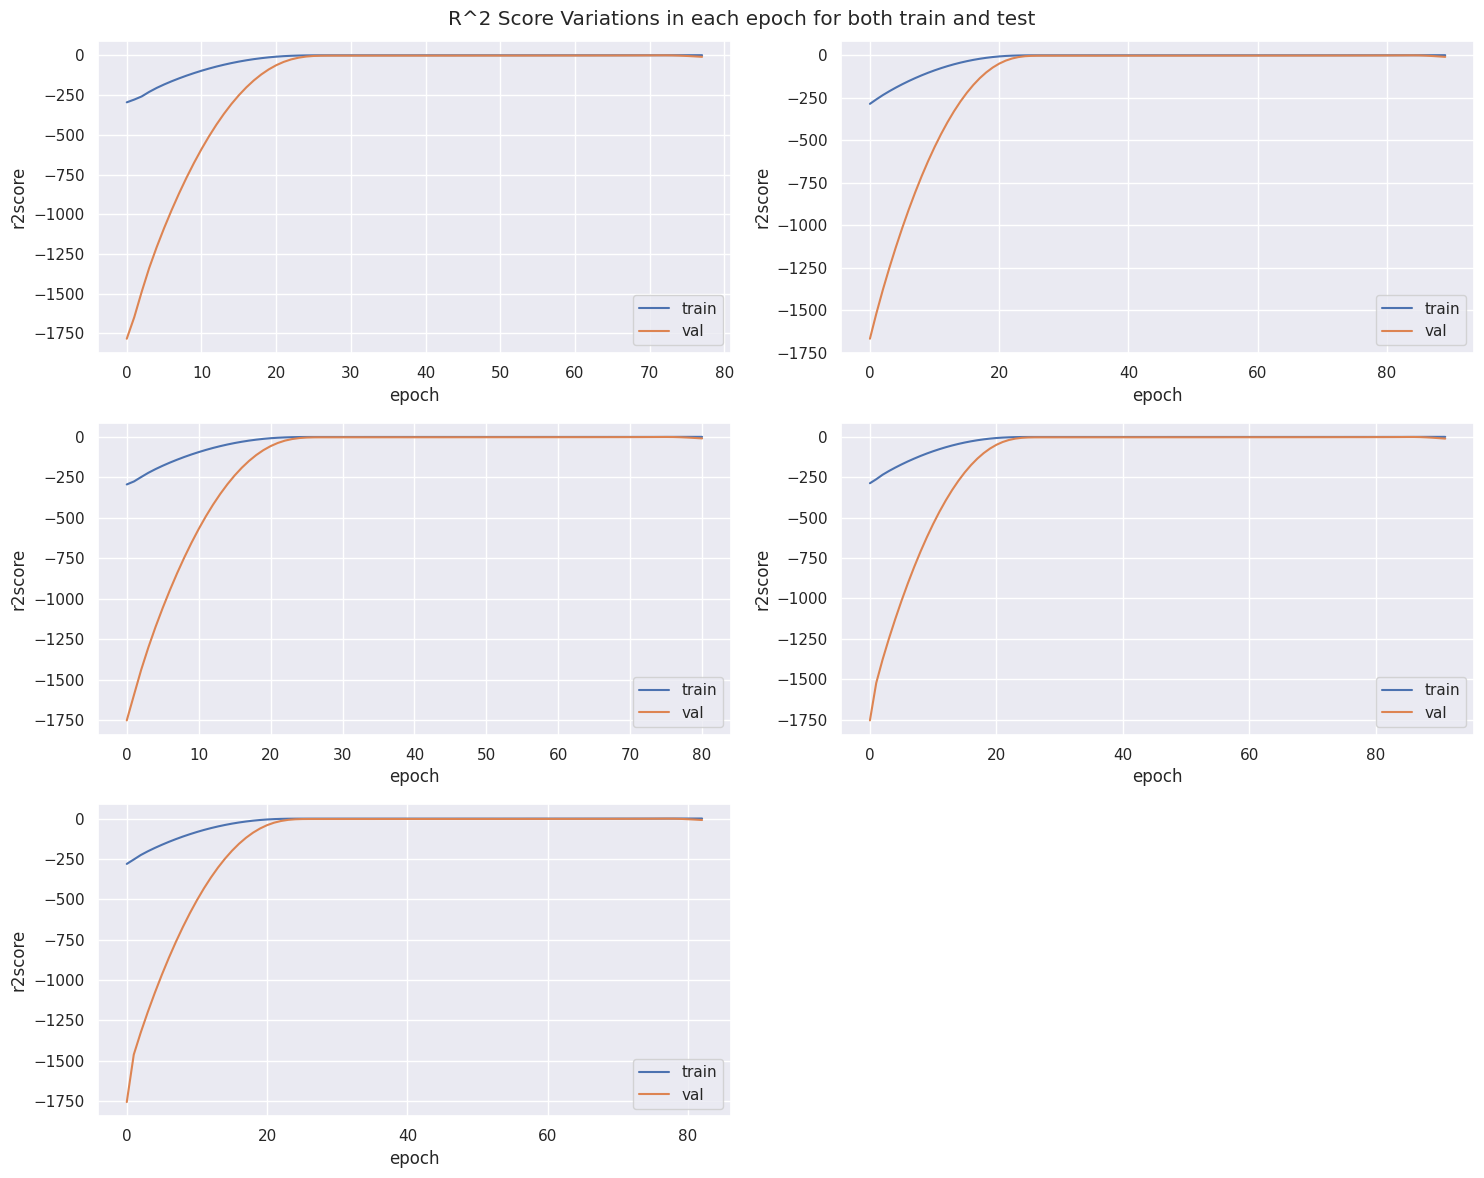

In [16]:
plt.figure(figsize = [15,12])
plt.suptitle("R^2 Score Variations in each epoch for both train and test")

for i, j in enumerate(datasets):
  plt.subplot(3, 2, i + 1)
  plt.plot(globals()[f"network_{j[1]}"].history["R2Score"])
  plt.plot(globals()[f"network_{j[1]}"].history["val_R2Score"])
  plt.ylabel('r2score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'best')

plt.tight_layout()
plt.show()

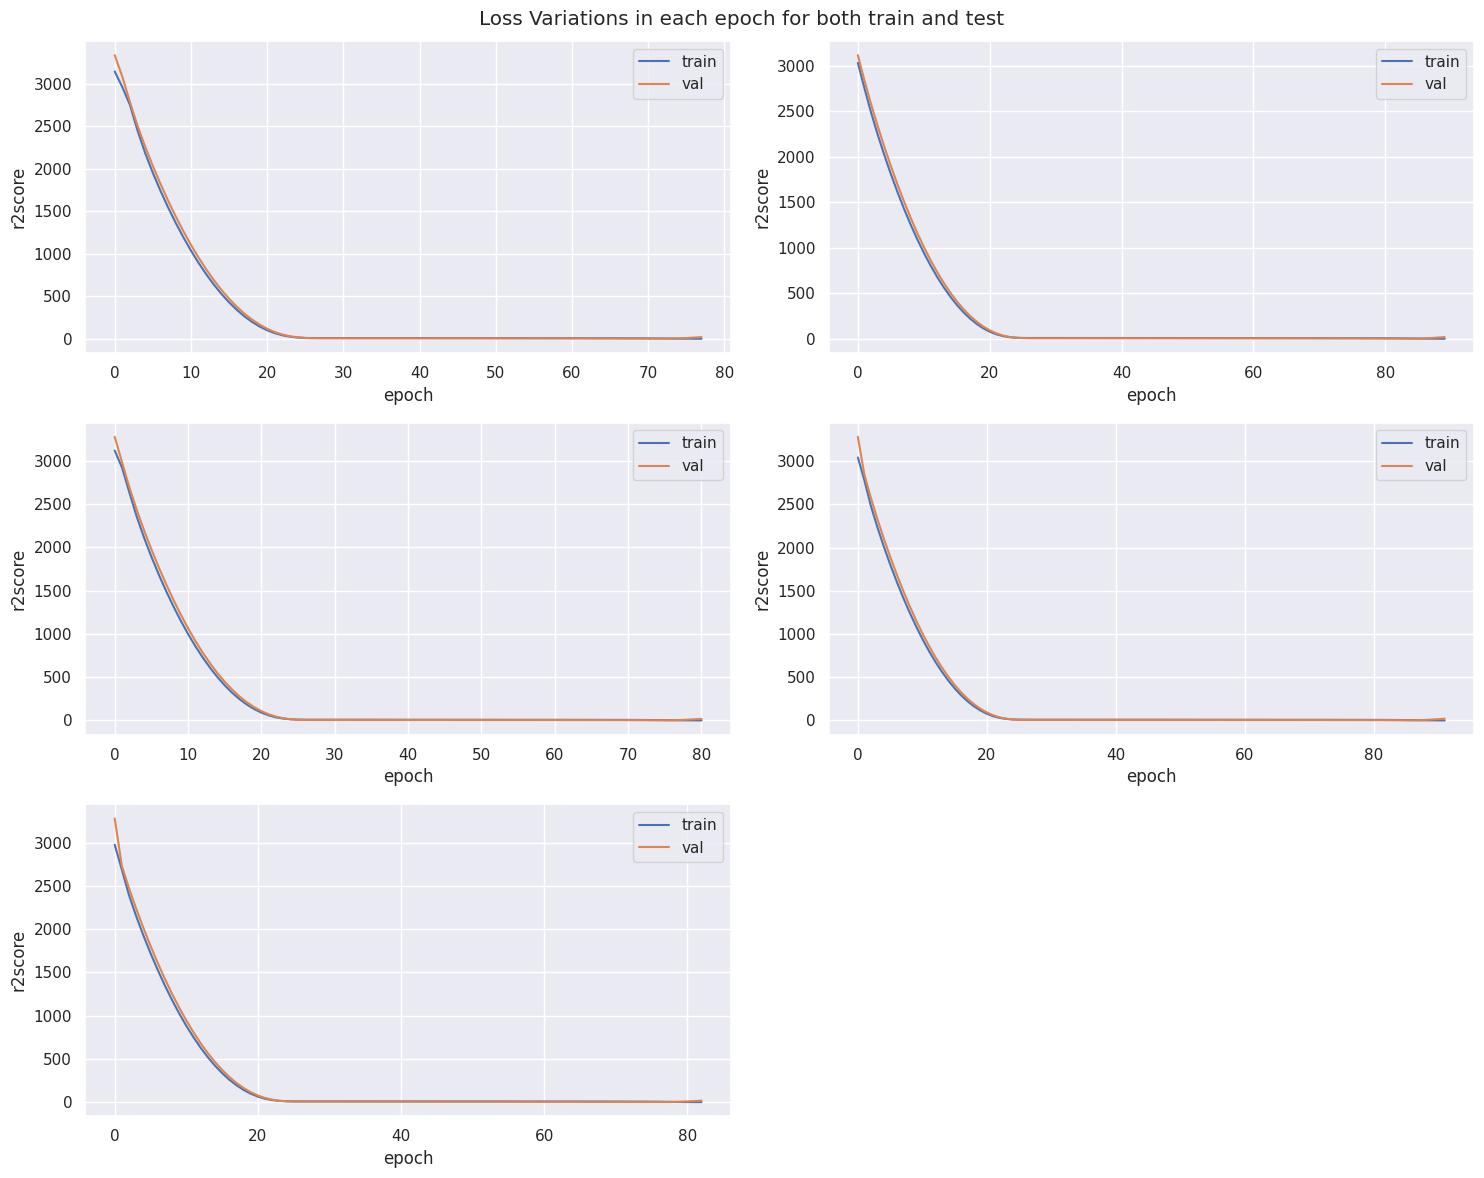

In [17]:
plt.figure(figsize = [15,12])
plt.suptitle("Loss Variations in each epoch for both train and test")

for i, j in enumerate(datasets):
  plt.subplot(3, 2, i + 1)
  plt.plot(globals()[f"network_{j[1]}"].history["loss"])
  plt.plot(globals()[f"network_{j[1]}"].history["val_loss"])
  plt.ylabel('r2score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'best')

plt.tight_layout()
plt.show()

In [26]:
y_hat = [np.concatenate((np.array(globals()[f"train_{name}"]), globals()[f"model_{name}"].predict(globals()[f"X_te_{name}"]).reshape(-1,))) for _, name, data in datasets]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [28]:
method_9_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_9_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_9_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_9_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"].iloc[:-5], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_9_metrics

,ac,bbd,cm,cnq,td
MSE,638.801294,3471.218887,2.08126,1054.443562,17.547386
MAE,25.223645,58.917049,1.285082,32.46082,3.959552
R^2,-247.654821,-634855.3119,-0.20531,-1426.423415,-8.386983


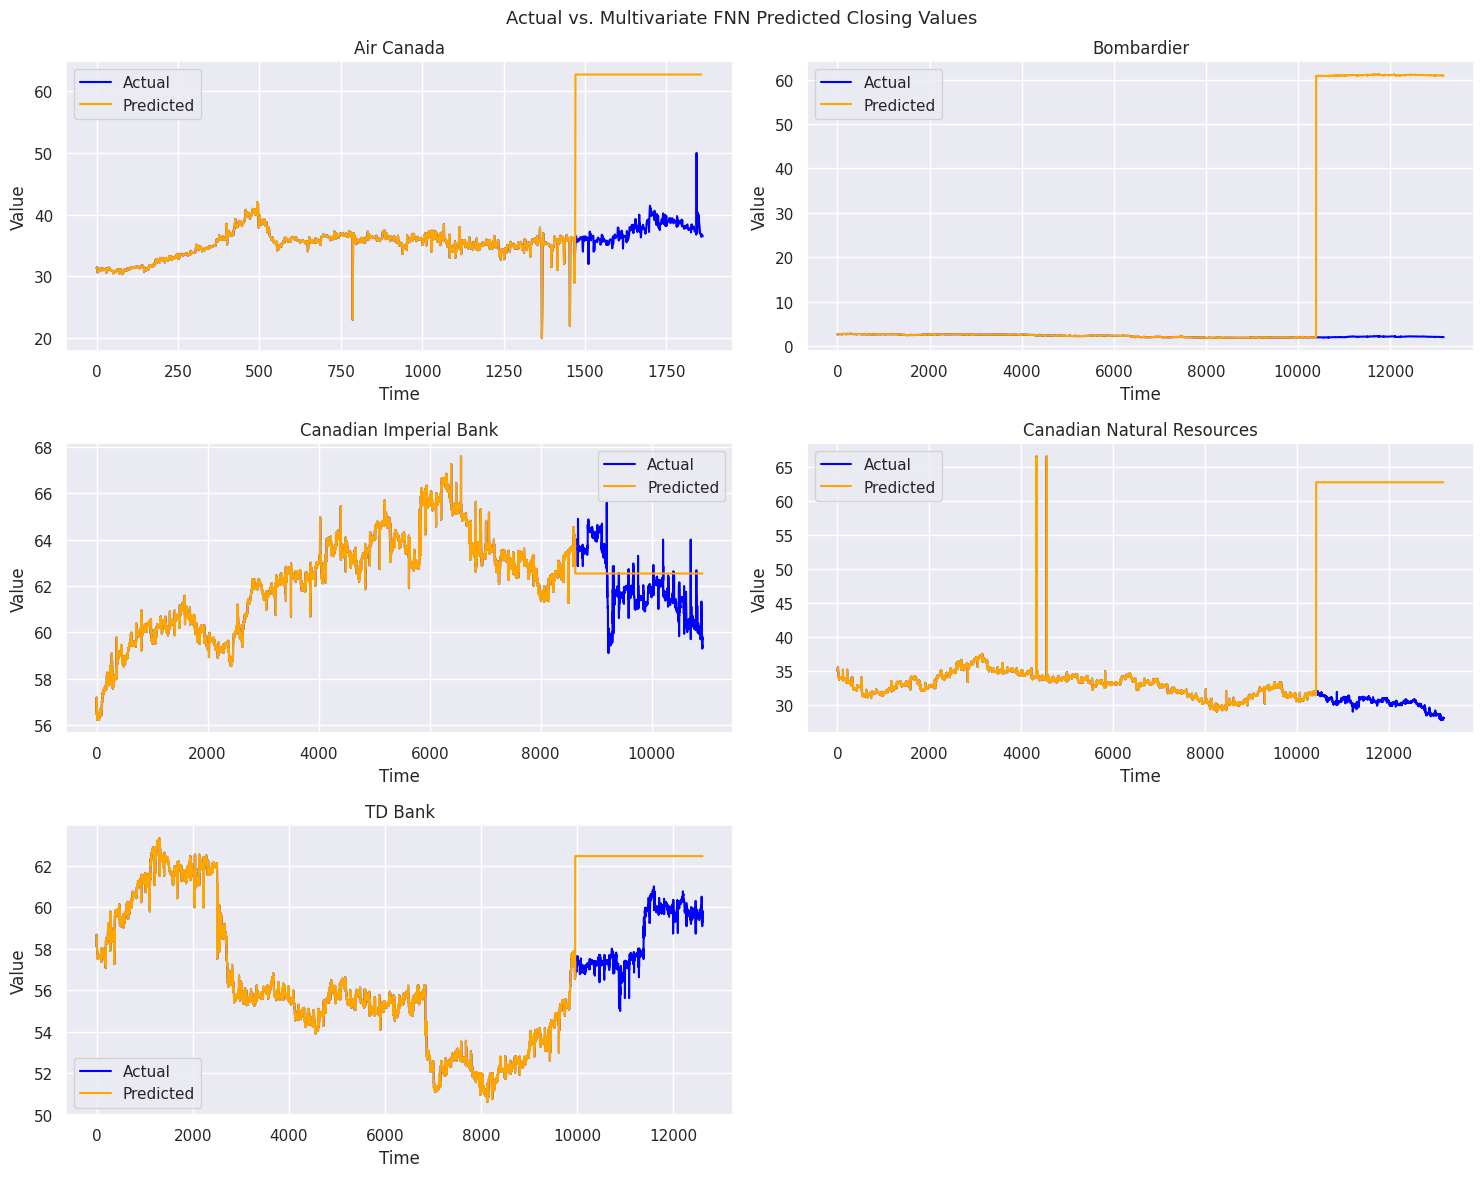

In [30]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. Multivariate FNN Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()

**Method 10 : 1-D CNN**

In [38]:
seq_len = 5
for _, val in enumerate(datasets):
    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = [], []
    for i in range(len(globals()[f"train_{val[1]}"]) - seq_len):
        globals()[f"X_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i : i + seq_len].to_list())
        globals()[f"y_tr_{val[1]}"].append(globals()[f"train_{val[1]}"].iloc[i + seq_len])

    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = [], []
    for j in range(len(globals()[f"test_{val[1]}"]) - seq_len):
        globals()[f"X_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j : j + seq_len].to_list())
        globals()[f"y_te_{val[1]}"].append(globals()[f"test_{val[1]}"].iloc[j + seq_len])

    globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"] = np.asarray(globals()[f"X_tr_{val[1]}"]), np.asarray(globals()[f"y_tr_{val[1]}"])
    globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"] = np.asarray(globals()[f"X_te_{val[1]}"]), np.asarray(globals()[f"y_te_{val[1]}"])

    globals()[f"X_tr_{val[1]}"] = (globals()[f"X_tr_{val[1]}"] - globals()[f"X_tr_{val[1]}"].mean(axis = 0)) / globals()[f"X_tr_{val[1]}"].std(axis = 0)
    globals()[f"X_te_{val[1]}"] = (globals()[f"X_te_{val[1]}"] - globals()[f"X_tr_{val[1]}"].mean(axis = 0)) / globals()[f"X_tr_{val[1]}"].std(axis = 0)

    globals()[f"X_tr_{val[1]}"], globals()[f"X_te_{val[1]}"] = globals()[f"X_tr_{val[1]}"][:, :, np.newaxis].repeat(3, axis = 2), globals()[f"X_te_{val[1]}"][:, :, np.newaxis].repeat(3, axis = 2)

In [39]:
for _, name, data in datasets:
  globals()[f"model_{name}"] = tf.keras.Sequential(
      [
          tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, activation = 'relu'),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv1D(filters = 128, kernel_size = 1, activation = 'relu'),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(units = 1, activation = 'linear')
      ]
  )

  globals()[f"model_{name}"].compile(optimizer = "adamw", loss = "mse", metrics = ["R2Score"])

  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor = "val_R2Score",
      patience = 10
  )

  globals()[f"network_{name}"] = globals()[f"model_{name}"].fit(
      globals()[f"X_tr_{val[1]}"], globals()[f"y_tr_{val[1]}"],
      validation_data = (globals()[f"X_te_{val[1]}"], globals()[f"y_te_{val[1]}"]),
      batch_size = 8,
      epochs = 1000,
      shuffle = True,
      callbacks = [early_stopping]
  )

Epoch 1/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - R2Score: -68.1676 - loss: 715.5024 - val_R2Score: -70185.9219 - val_loss: 131110.8594
Epoch 2/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -0.2095 - loss: 12.8503 - val_R2Score: -55774.1680 - val_loss: 104189.3594
Epoch 3/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: -0.0539 - loss: 11.2107 - val_R2Score: -31040.5176 - val_loss: 57986.3047
Epoch 4/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - R2Score: 0.0976 - loss: 9.4354 - val_R2Score: -23759.0703 - val_loss: 44384.3867
Epoch 5/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - R2Score: 0.2217 - loss: 8.4239 - val_R2Score: -25114.8828 - val_loss: 46917.0781
Epoch 6/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - R2Score: 0.3281 - loss: 7.1796 - val_R2Score: -32912.9648 - val_loss: 61484.0781
Epoch 7/1000
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - R2Score: 0.4360 - loss: 5.9405 - val_R2Score: -19229.5137 - val_loss: 35923.0625
Epoch 8/1000
1245

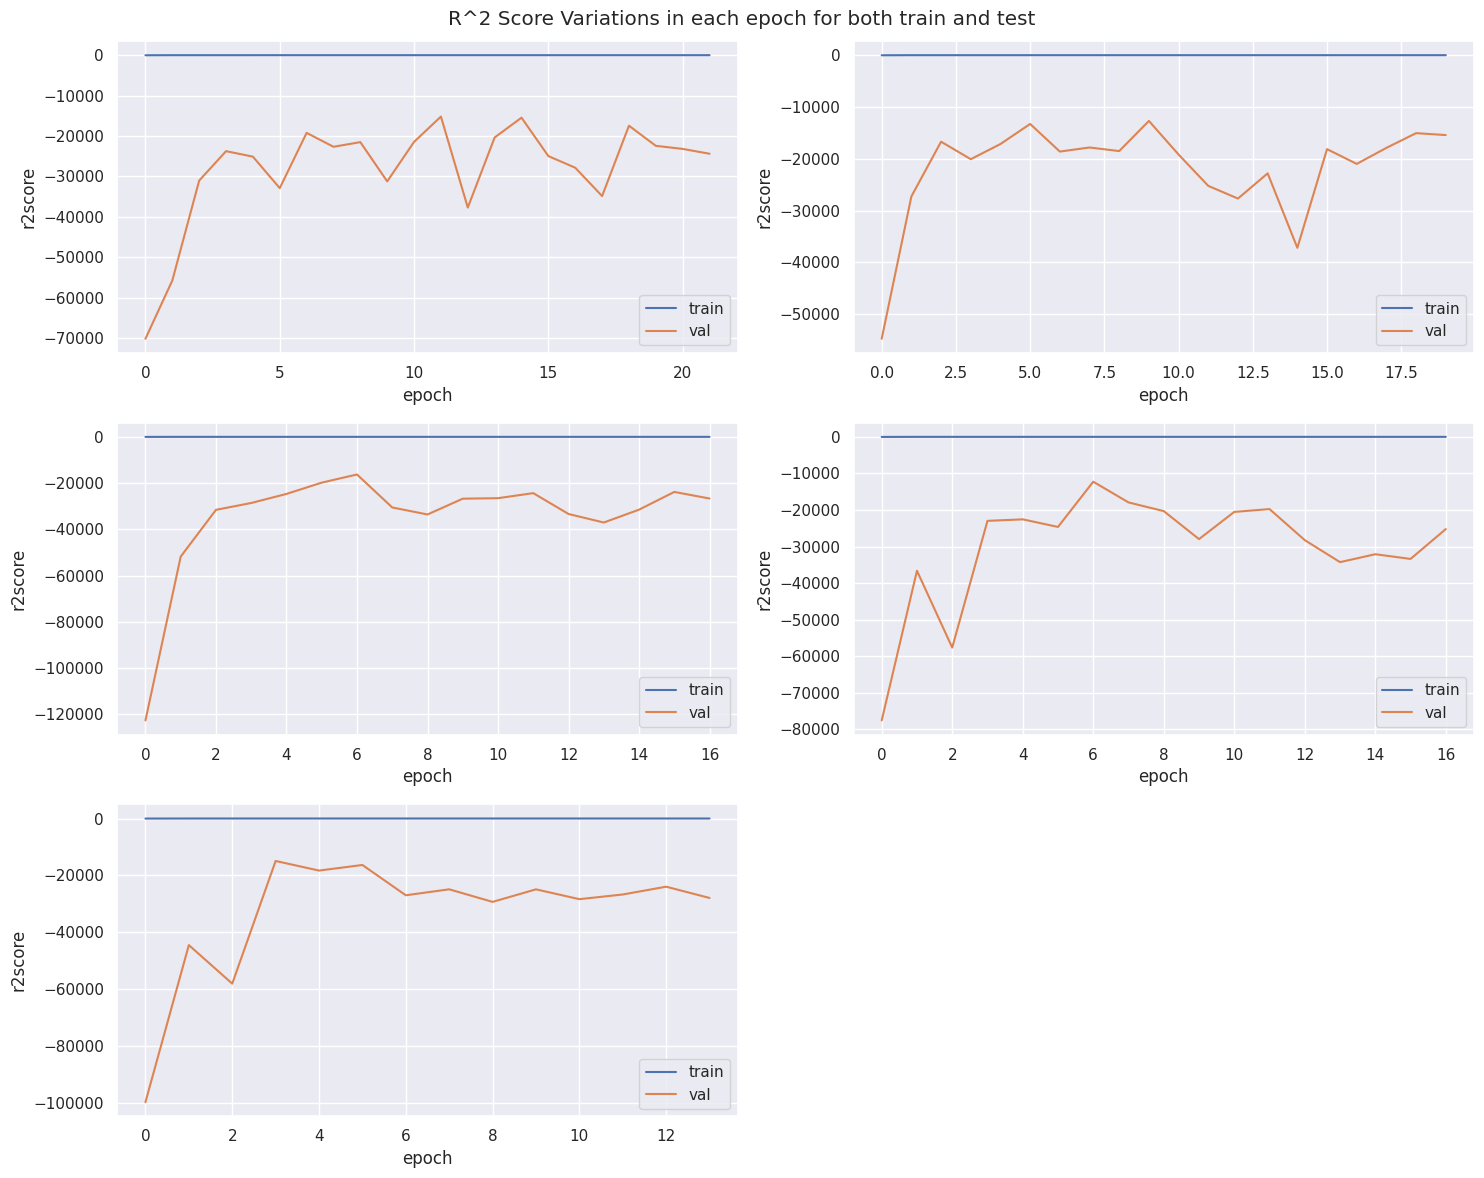

In [40]:
plt.figure(figsize = [15,12])
plt.suptitle("R^2 Score Variations in each epoch for both train and test")

for i, j in enumerate(datasets):
  plt.subplot(3, 2, i + 1)
  plt.plot(globals()[f"network_{j[1]}"].history["R2Score"])
  plt.plot(globals()[f"network_{j[1]}"].history["val_R2Score"])
  plt.ylabel('r2score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'best')

plt.tight_layout()
plt.show()

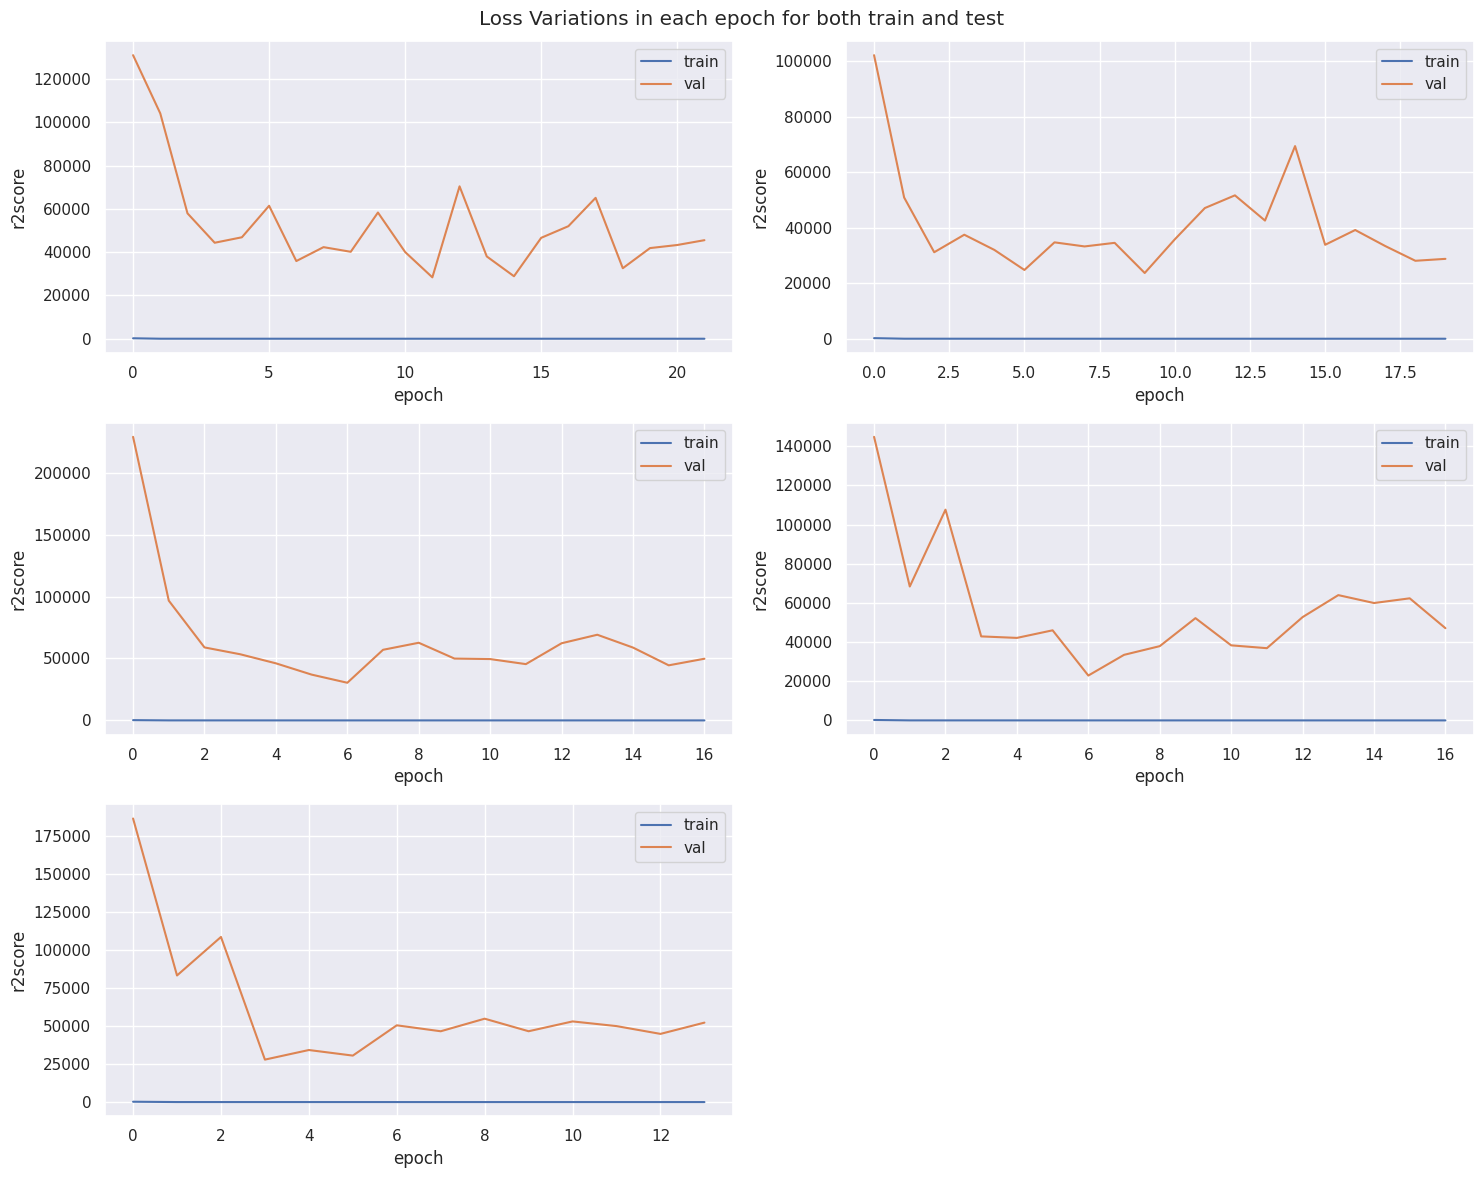

In [41]:
plt.figure(figsize = [15,12])
plt.suptitle("Loss Variations in each epoch for both train and test")

for i, j in enumerate(datasets):
  plt.subplot(3, 2, i + 1)
  plt.plot(globals()[f"network_{j[1]}"].history["loss"])
  plt.plot(globals()[f"network_{j[1]}"].history["val_loss"])
  plt.ylabel('r2score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc = 'best')

plt.tight_layout()
plt.show()

In [42]:
y_hat = [np.concatenate((np.array(globals()[f"train_{name}"]), globals()[f"model_{name}"].predict(globals()[f"X_te_{name}"]).reshape(-1,))) for _, name, data in datasets]

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [43]:
method_10_metrics = pd.DataFrame(columns =  [name for _, name, data in datasets], index = ["MSE", "MAE", "R^2"])

for idx, val in enumerate(datasets):
    method_10_metrics.iloc[0,idx] = mean_squared_error(globals()[f"test_{val[1]}"].iloc[:-seq_len], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_10_metrics.iloc[1,idx] = mean_absolute_error(globals()[f"test_{val[1]}"].iloc[:-seq_len], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])
    method_10_metrics.iloc[2,idx] = r2_score(globals()[f"test_{val[1]}"].iloc[:-seq_len], y_hat[idx][globals()[f"test_{val[1]}"].index[0]:])

method_10_metrics

,ac,bbd,cm,cnq,td
MSE,23262.299601,3588.145868,54684.995883,17550.040361,52237.135863
MAE,152.446238,59.900979,233.812584,132.452234,228.513081
R^2,-9053.901732,-656240.258942,-31668.460408,-23756.875209,-27943.283963


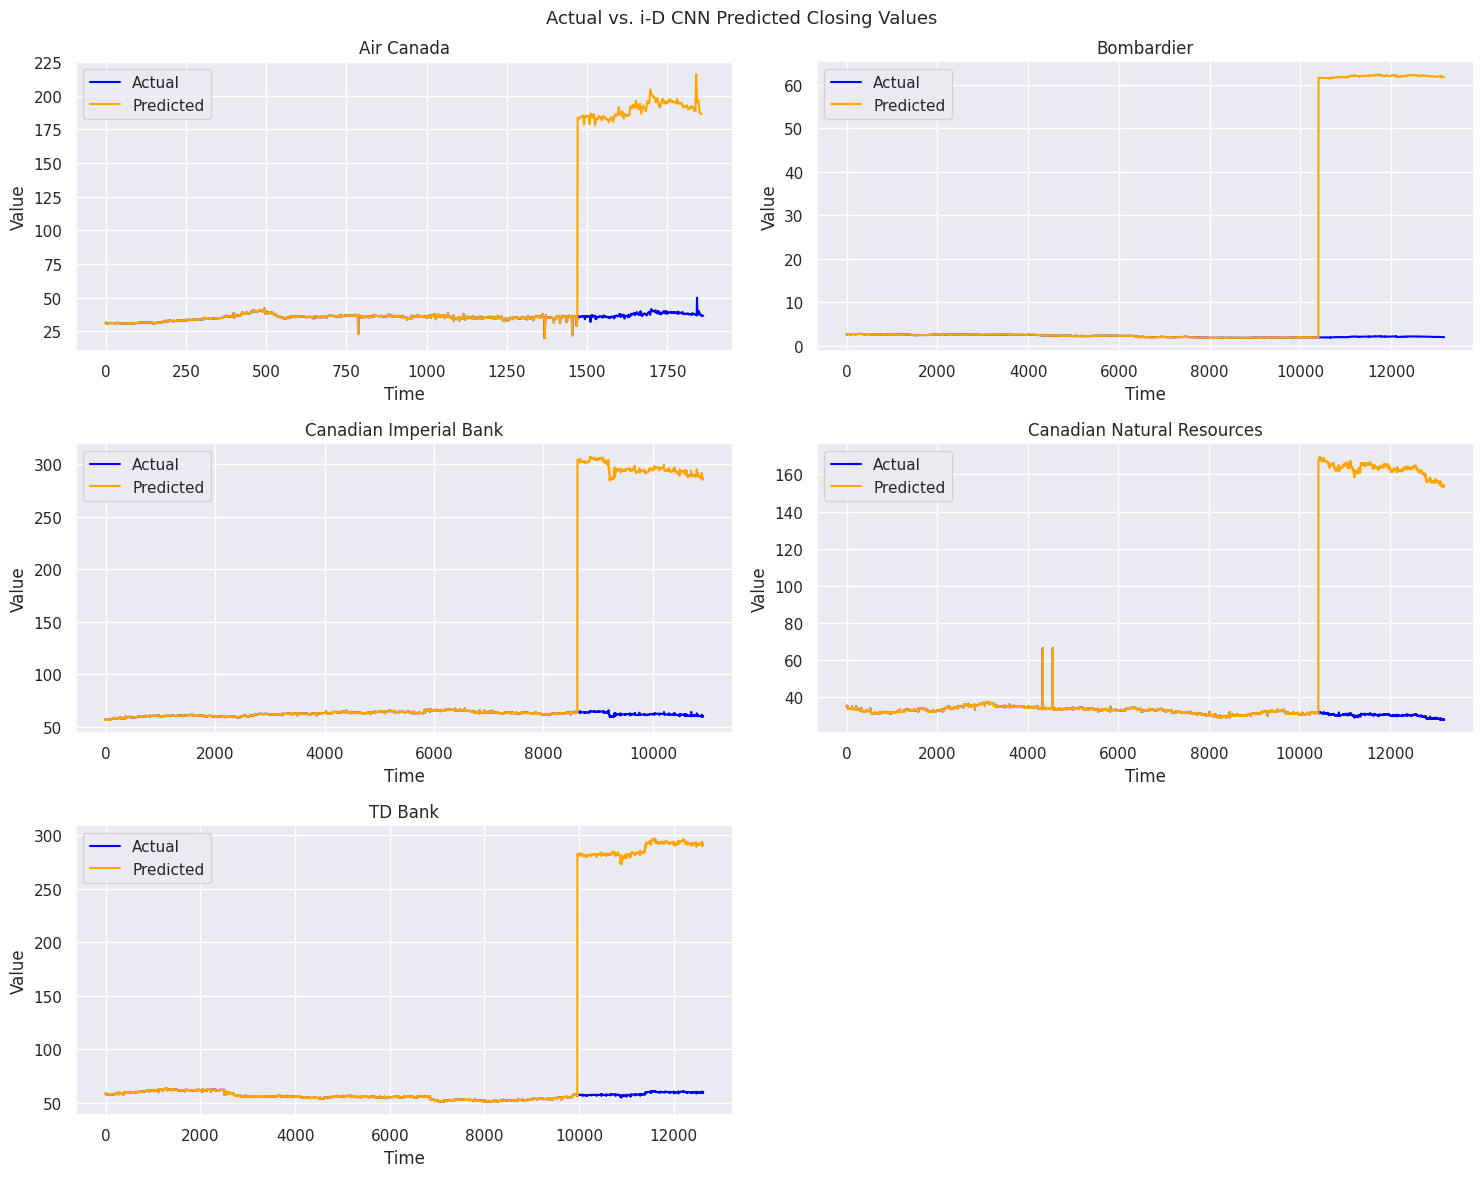

In [44]:
plt.figure(figsize = [15,12])
plt.suptitle("Actual vs. i-D CNN Predicted Closing Values", fontsize = 13)

for _, data in enumerate(datasets):
    plt.subplot(3,2,_ + 1)
    plt.plot(np.concatenate((globals()[f"train_{data[1]}"], globals()[f"test_{data[1]}"])), label = "Actual", color = "blue")
    plt.plot(y_hat[_], label = "Predicted", color = "orange")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(loc = "best")
    plt.title(data[0])

plt.tight_layout()
plt.show()